In [1]:
from pandas import read_csv
from datetime import datetime
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
import pandas as pd


Using TensorFlow backend.


In [2]:
#Extracts data from file 'US Data.xlsx': the file contains information on Apple stock. The variables can be described
#in 3 categories: 1) Technical data: Open Price, Last Price, Volume.
#2) Fundamental data: Financial Leverage, PE RATIO, Cash Flow per Share, Price to Book Ratio, Dividend Per Share. 
#3) Macro data: SPX, VIX, PPUT,
#Note: VIX - volatility index; PPUT - put option price for S&P; SPX - S&P price
data=pd.read_excel('US Data.xlsx')

In [3]:
data.head()

,Date,Open Price,Last Price,Financial Leverage,Volume,PE RATIO,Cash Flow Per Share,Price to Book Ratio,Dividend Per Share,SPX,VIX,PPUT
0,2014-02-03,71.8014,71.6471,1.7067,100620772,12.4425,3.6142,3.4514,0.4357,1741.89,21.44,593.43
1,2014-02-04,72.2643,72.6843,1.7067,94273543,12.6226,3.6142,3.5013,0.4357,1755.20,19.11,594.46
2,2014-02-05,72.3657,73.2271,1.7067,82322156,12.7169,3.6142,3.5275,0.4357,1751.64,19.95,594.10
3,2014-02-06,72.8657,73.2157,1.7067,64497223,12.7149,3.6142,3.5269,0.4357,1773.43,17.23,597.95
4,2014-02-07,74.4829,74.2400,1.7067,93638601,12.8928,3.6142,3.5763,0.4357,1797.02,15.29,603.01


In [4]:
data.describe()

,Open Price,Last Price,Financial Leverage,Volume,PE RATIO,Cash Flow Per Share,Price to Book Ratio,Dividend Per Share,SPX,VIX,PPUT
count,1380.000000,1380.000000,1380.000000,1.380000e+03,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000
mean,137.631201,137.681379,2.475385,4.050571e+07,15.359991,3.233181,5.888355,0.575685,2321.858167,14.952551,743.758797
std,39.028113,39.052239,0.465252,2.118245e+07,2.504819,1.298186,1.502929,0.097161,342.581722,4.147436,96.290575
min,71.801400,71.647100,1.706700,1.136204e+07,9.962100,1.678300,3.451400,0.435700,1741.890000,9.140000,593.430000
25%,107.362500,107.327500,2.098100,2.585018e+07,13.296450,2.233000,4.725175,0.470000,2047.092500,12.180000,665.707500
50%,127.015000,126.835000,2.462000,3.488049e+07,15.714300,2.967500,5.653150,0.570000,2180.385000,13.910000,696.495000
75%,170.977500,170.975000,2.851900,4.977487e+07,17.308525,4.065900,6.482625,0.630000,2658.585000,16.410000,835.547500
max,230.780000,232.070000,3.285800,1.899781e+08,20.950300,5.771300,10.298800,0.770000,3025.860000,40.740000,959.410000


In [5]:
#set date to be the index
data.set_index('Date', inplace=True)
data.head()

,Open Price,Last Price,Financial Leverage,Volume,PE RATIO,Cash Flow Per Share,Price to Book Ratio,Dividend Per Share,SPX,VIX,PPUT
Date,,,,,,,,,,,
2014-02-03,71.8014,71.6471,1.7067,100620772,12.4425,3.6142,3.4514,0.4357,1741.89,21.44,593.43
2014-02-04,72.2643,72.6843,1.7067,94273543,12.6226,3.6142,3.5013,0.4357,1755.20,19.11,594.46
2014-02-05,72.3657,73.2271,1.7067,82322156,12.7169,3.6142,3.5275,0.4357,1751.64,19.95,594.10
2014-02-06,72.8657,73.2157,1.7067,64497223,12.7149,3.6142,3.5269,0.4357,1773.43,17.23,597.95
2014-02-07,74.4829,74.2400,1.7067,93638601,12.8928,3.6142,3.5763,0.4357,1797.02,15.29,603.01


In [6]:
#check if any NA
data.isna().any()

Open Price             False
Last Price             False
Financial Leverage     False
Volume                 False
PE RATIO               False
Cash Flow Per Share    False
Price to Book Ratio    False
Dividend Per Share     False
SPX                    False
VIX                    False
PPUT                   False
dtype: bool

As per isna check, it is a very clean dataset.

In [7]:
#reorder the columns and resort the column order (keep Last Price the last column for convenience in the next step)
col=list(data.columns)
cols_to_order = ['Last Price']
new_col = (data.columns.drop(cols_to_order).tolist())+cols_to_order 
data=data[new_col]
data.head()

,Open Price,Financial Leverage,Volume,PE RATIO,Cash Flow Per Share,Price to Book Ratio,Dividend Per Share,SPX,VIX,PPUT,Last Price
Date,,,,,,,,,,,
2014-02-03,71.8014,1.7067,100620772,12.4425,3.6142,3.4514,0.4357,1741.89,21.44,593.43,71.6471
2014-02-04,72.2643,1.7067,94273543,12.6226,3.6142,3.5013,0.4357,1755.20,19.11,594.46,72.6843
2014-02-05,72.3657,1.7067,82322156,12.7169,3.6142,3.5275,0.4357,1751.64,19.95,594.10,73.2271
2014-02-06,72.8657,1.7067,64497223,12.7149,3.6142,3.5269,0.4357,1773.43,17.23,597.95,73.2157
2014-02-07,74.4829,1.7067,93638601,12.8928,3.6142,3.5763,0.4357,1797.02,15.29,603.01,74.2400


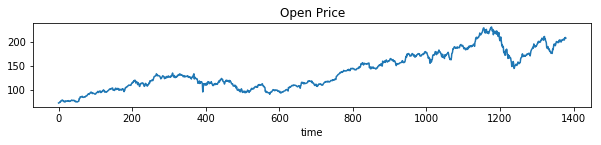

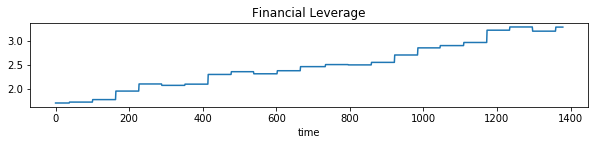

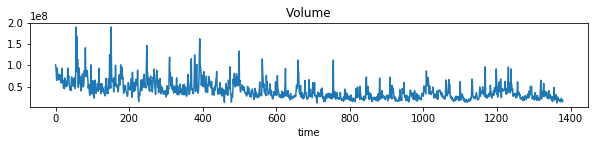

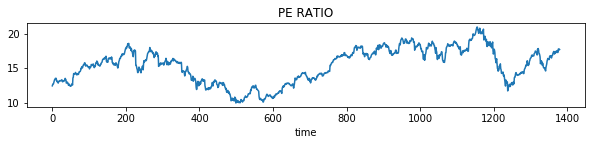

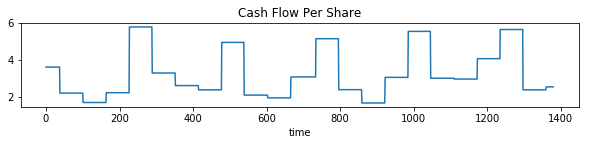

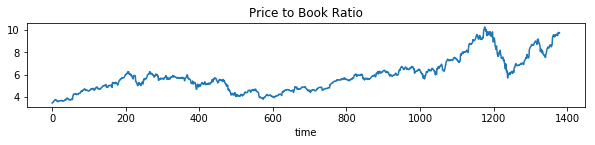

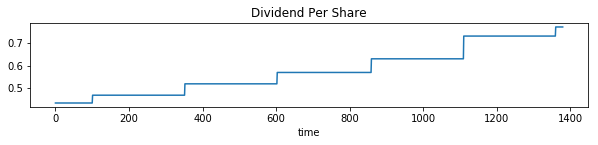

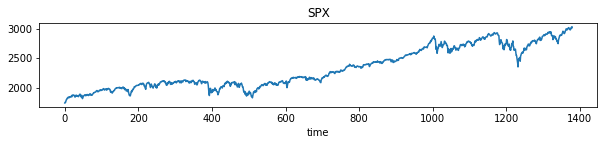

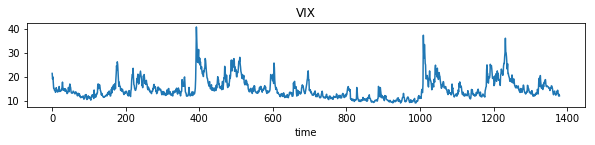

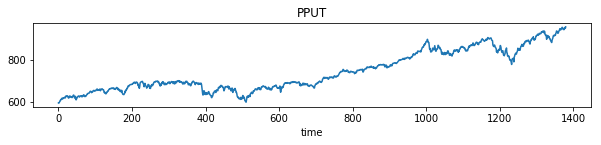

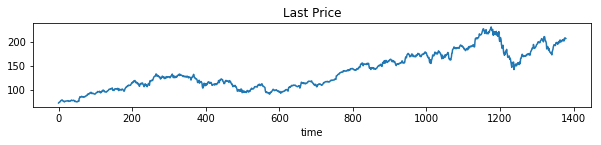

In [11]:
#plot the dataset
from matplotlib import pyplot
values=data.values
groups=[0,1,2,3,4,5,6,7,8,9,10]
i=1

for group in groups:
    pyplot.figure(figsize=(10,20))
    pyplot.subplot(len(groups),1,i)
    pyplot.plot(values[:, group])
    pyplot.title(data.columns[group])
    i+=1
    pyplot.xlabel("time")
    pyplot.show()

Graphs above suggests that there is no abnormality with the dataset. As expected, fundamental data have a step function curve shape due to quarter reporting.

In [9]:
#convert the raw data to multivariant dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
   
    n_vars=1 if type(data) is list else data.shape[1]
  
    df=DataFrame(data)
    cols, names=list(), list()
    for i in range(n_in, 0,-1):
        cols.append(df.shift(i))
        names+=[('var%d(t-%d)'%(j+1,i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i==0:
            names+=[('var%d(t)'%(j+1)) for j in range(n_vars)]
        else:
            names+=[('var%d(t+%d)'%(j+1, i)) for j in range(n_vars)]
    agg=concat(cols, axis=1)
    agg.columns=names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

                

In [10]:
#rescale the dataset
scaler=MinMaxScaler(feature_range=(0,1))
scaled=scaler.fit_transform(values)

#set training set to be 90% of the total set, and testing 10%
n_train = int(len(scaled)*0.9)
n_test=len(scaled)-n_train
print('number of training set: ', n_train)
print('number of test set: ', n_test)


number of training set:  1242
number of test set:  138


In [12]:
#Model 1: a simple model with one LSTM layer and one dense layer
def model1(train_X, train_y,test_X, LSTM_nodes):
    '''
    Model 1: simple 1 layer LSTM + 1 dense layer 
    Input: train_X, train_y, test_X, LSTM_nodes
    Output: predicted y value for test_X
    '''
    model=Sequential()
    model.add(LSTM(LSTM_nodes, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    model.summary()
    history=model.fit(train_X, train_y, epochs=20, batch_size=72, verbose=2, shuffle=False)

    pred=model.predict(test_X)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.legend()
    pyplot.show()
    return pred
    

In [13]:
#Model 2: 1 LSTM layers + 2 dense layers with linear activation
def model2(train_X, train_y,test_X, LSTM_nodes):
    '''
    Model 2: 1 layer LSTM + dropout (0.5) + 1 dense layer + dropout(0.5) + 1 dense layer, linear activation
    Input: train_X, train_y, test_X, LSTM_nodes
    Output: predicted y value for test_X
    '''
    model2=Sequential()
    model2.add(LSTM(LSTM_nodes, input_shape=(train_X.shape[1], train_X.shape[2])))
    model2.add(Dropout(0.5))
    model2.add(Dense(32, activation='linear'))
    model2.add(Dropout(0.5))
    model2.add(Dense(1, activation='linear'))
    model2.compile(loss='mae', optimizer='adam')
    model2.summary()
    history2=model2.fit(train_X, train_y, epochs=30, batch_size=72, verbose=2, shuffle=False)

    pred2=model2.predict(test_X)
    pyplot.plot(history2.history['loss'], label='train loss')
    pyplot.legend()
    pyplot.show()
    return pred2

In [14]:
#Model 3: 3 LSTM layers with linear dense layers
def model3(train_X, train_y,test_X,LSTM_nodes):
    '''
    Model 3: 3 layer LSTM + 2 dense layer with dropout in between and linear activation
    Input: train_X, train_y, test_X, LSTM_nodes
    Output: predicted y value for test_X
    '''
    model3=Sequential()
    model3.add(LSTM(LSTM_nodes, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
    model3.add(Dropout(0.3))
    model3.add(LSTM(LSTM_nodes, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
    model3.add(Dropout(0.3))
    model3.add(LSTM(LSTM_nodes,input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=False))
    model3.add(Dropout(0.3))
    model3.add(Dense(20, activation='linear'))
    model3.add(Dropout(0.3))
    model3.add(Dense(1, activation='linear'))
    model3.compile(loss='mae', optimizer='adam')

    history3=model3.fit(train_X, train_y, epochs=30, batch_size=72,  verbose=2, shuffle=False)

    pred3=model3.predict(test_X)
    pyplot.plot(history3.history['loss'], label='train')
    pyplot.legend()
    pyplot.show()
    return pred3

In [15]:
#bring target outcome back to its orignal scale
ymax=data['Last Price'].max()
ymin=data['Last Price'].min()

#n_features are features for prediction, and there are 11 columns for the previous n_days
n_features=11

#n_days is number of days one would like to go back in time from time (t). ie predicting closing price at time t 
#based on past n_day 11 data points. 
#We are testing 5, 10, and 20 days as selected n_days here.
n_days=[5, 10, 20]

#We are testing 4 different node size for LSTM_nodes
LSTM_nodes=[30,40,50, 60]

In [16]:
def run_model(model, scaled, LSTM_nodes):
    '''
    run_model: testing different model with different nodes 
    Input: model, scaled (dataset), LSTM_nodes
    Output: print out each model results with different LSTM_nodes and its graph. In the end, select the best result.
    '''
    for n in n_days:

        print('n_days = ', n)
        reframed=series_to_supervised(scaled,n,1)
        reframed.head()
        values=reframed.values
        #n_obs is number of observation needed to predict any given day's closing price
        n_obs=n*n_features
        print('n_obs: ', n_obs)
        train = values[:n_train, :]
        test = values[n_train:, :]

        # split into input and outputs
        train_X, train_y = train[:, :n_obs], train[:, -1]
        test_X, test_y = test[:, :n_obs], test[:, -1]

        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], n, n_features))
        test_X = test_X.reshape((test_X.shape[0], n, n_features))
        test_y=test_y*(ymax-ymin)+ymin
        
        for i in LSTM_nodes:
            print('LSTM_nodes: ', i)
            yhat= model(train_X,train_y,test_X,i)
            yhat=yhat*(ymax-ymin)+ymin 
            mse=mean_squared_error(test_y, yhat)
            if n==n_days[0] or best_mse>mse:
                best_nodes=i
                best_mse = mse
                best_n=n
                best_yhat=yhat
                best_test_y=test_y
   
    pyplot.plot(best_yhat, color='g',  label='Predicted')
    pyplot.plot(best_test_y, color='r', label='Actual')
    pyplot.ylabel('Closing Price')
    pyplot.xlabel('Days')
    pyplot.title('Best Model result: LSTM nodes ={}, n = {}, and MSE ={} '.format(best_nodes,best_n, best_mse))
    pyplot.legend()
    pyplot.show()
    
    return

W1007 23:09:55.120363 4703999424 deprecation_wrapper.py:119] From /Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1007 23:09:55.211066 4703999424 deprecation_wrapper.py:119] From /Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1007 23:09:55.233660 4703999424 deprecation_wrapper.py:119] From /Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



n_days =  5
n_obs:  55
LSTM_nodes:  30


W1007 23:09:55.496560 4703999424 deprecation_wrapper.py:119] From /Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1007 23:09:55.705224 4703999424 deprecation.py:323] From /Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                5040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 5,071
Trainable params: 5,071
Non-trainable params: 0
_________________________________________________________________


W1007 23:09:56.325196 4703999424 deprecation_wrapper.py:119] From /Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1007 23:09:56.475439 4703999424 deprecation_wrapper.py:119] From /Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
 - 1s - loss: 0.2698
Epoch 2/20
 - 0s - loss: 0.1073
Epoch 3/20
 - 0s - loss: 0.0955
Epoch 4/20
 - 0s - loss: 0.0501
Epoch 5/20
 - 0s - loss: 0.0474
Epoch 6/20
 - 0s - loss: 0.0414
Epoch 7/20
 - 0s - loss: 0.0355
Epoch 8/20
 - 0s - loss: 0.0327
Epoch 9/20
 - 0s - loss: 0.0322
Epoch 10/20
 - 0s - loss: 0.0321
Epoch 11/20
 - 0s - loss: 0.0322
Epoch 12/20
 - 0s - loss: 0.0294
Epoch 13/20
 - 0s - loss: 0.0312
Epoch 14/20
 - 0s - loss: 0.0430
Epoch 15/20
 - 0s - loss: 0.0545
Epoch 16/20
 - 0s - loss: 0.0494
Epoch 17/20
 - 0s - loss: 0.0303
Epoch 18/20
 - 0s - loss: 0.0393
Epoch 19/20
 - 0s - loss: 0.0413
Epoch 20/20
 - 0s - loss: 0.0420


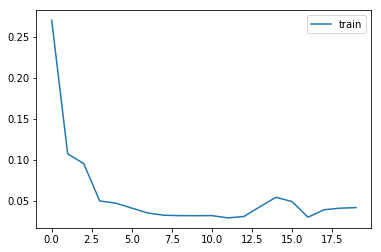

LSTM_nodes:  40
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 40)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total params: 8,361
Trainable params: 8,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
 - 1s - loss: 0.0887
Epoch 2/20
 - 0s - loss: 0.1204
Epoch 3/20
 - 0s - loss: 0.0433
Epoch 4/20
 - 0s - loss: 0.0515
Epoch 5/20
 - 0s - loss: 0.0404
Epoch 6/20
 - 0s - loss: 0.0277
Epoch 7/20
 - 0s - loss: 0.0261
Epoch 8/20
 - 0s - loss: 0.0251
Epoch 9/20
 - 0s - loss: 0.0230
Epoch 10/20
 - 0s - loss: 0.0272
Epoch 11/20
 - 0s - loss: 0.0542
Epoch 12/20
 - 0s - loss: 0.0622
Epoch 13/20
 - 0s - loss: 0.0285
Epoch 14/20
 - 0s - loss: 0.0518
Epoch 15/20
 - 0s - loss: 0.0654
Epoch 16/20
 - 0s - loss: 0.0590
E

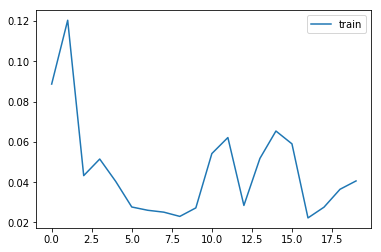

LSTM_nodes:  50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                12400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
 - 1s - loss: 0.1341
Epoch 2/20
 - 0s - loss: 0.1621
Epoch 3/20
 - 0s - loss: 0.0807
Epoch 4/20
 - 0s - loss: 0.0546
Epoch 5/20
 - 0s - loss: 0.0421
Epoch 6/20
 - 0s - loss: 0.0374
Epoch 7/20
 - 0s - loss: 0.0321
Epoch 8/20
 - 0s - loss: 0.0302
Epoch 9/20
 - 0s - loss: 0.0293
Epoch 10/20
 - 0s - loss: 0.0285
Epoch 11/20
 - 0s - loss: 0.0281
Epoch 12/20
 - 0s - loss: 0.0279
Epoch 13/20
 - 0s - loss: 0.0266
Epoch 14/20
 - 0s - loss: 0.0333
Epoch 15/20
 - 0s - loss: 0.0389
Epoch 16/20
 - 0s - loss: 0.0277

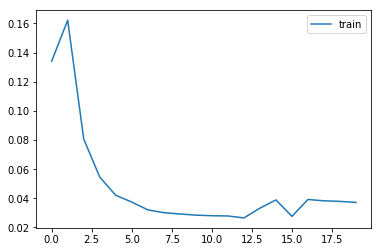

LSTM_nodes:  60
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60)                17280     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 61        
Total params: 17,341
Trainable params: 17,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
 - 1s - loss: 0.0481
Epoch 2/20
 - 0s - loss: 0.1534
Epoch 3/20
 - 0s - loss: 0.0512
Epoch 4/20
 - 0s - loss: 0.0333
Epoch 5/20
 - 0s - loss: 0.0376
Epoch 6/20
 - 0s - loss: 0.0461
Epoch 7/20
 - 0s - loss: 0.0682
Epoch 8/20
 - 0s - loss: 0.0355
Epoch 9/20
 - 0s - loss: 0.0478
Epoch 10/20
 - 0s - loss: 0.0254
Epoch 11/20
 - 0s - loss: 0.0392
Epoch 12/20
 - 0s - loss: 0.0426
Epoch 13/20
 - 0s - loss: 0.0310
Epoch 14/20
 - 0s - loss: 0.0612
Epoch 15/20
 - 0s - loss: 0.0550
Epoch 16/20
 - 0s - loss: 0.0716

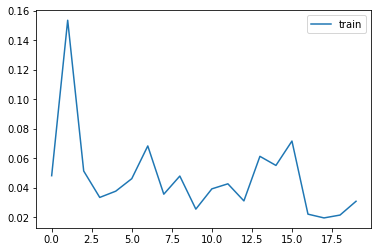

n_days =  10
n_obs:  110
LSTM_nodes:  30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30)                5040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 5,071
Trainable params: 5,071
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
 - 1s - loss: 0.1773
Epoch 2/20
 - 0s - loss: 0.1161
Epoch 3/20
 - 0s - loss: 0.0795
Epoch 4/20
 - 0s - loss: 0.0498
Epoch 5/20
 - 0s - loss: 0.0319
Epoch 6/20
 - 0s - loss: 0.0276
Epoch 7/20
 - 0s - loss: 0.0350
Epoch 8/20
 - 0s - loss: 0.0430
Epoch 9/20
 - 0s - loss: 0.0331
Epoch 10/20
 - 0s - loss: 0.0581
Epoch 11/20
 - 0s - loss: 0.0518
Epoch 12/20
 - 0s - loss: 0.0629
Epoch 13/20
 - 0s - loss: 0.0258
Epoch 14/20
 - 0s - loss: 0.0407
Epoch 15/20
 - 0s - loss: 0.0386
Epoch 16/

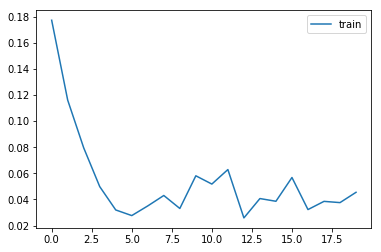

LSTM_nodes:  40
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 40)                8320      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
Total params: 8,361
Trainable params: 8,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
 - 1s - loss: 0.0899
Epoch 2/20
 - 0s - loss: 0.1768
Epoch 3/20
 - 0s - loss: 0.0688
Epoch 4/20
 - 0s - loss: 0.0610
Epoch 5/20
 - 0s - loss: 0.0421
Epoch 6/20
 - 0s - loss: 0.0337
Epoch 7/20
 - 0s - loss: 0.0301
Epoch 8/20
 - 0s - loss: 0.0275
Epoch 9/20
 - 0s - loss: 0.0280
Epoch 10/20
 - 0s - loss: 0.0531
Epoch 11/20
 - 0s - loss: 0.0797
Epoch 12/20
 - 0s - loss: 0.0353
Epoch 13/20
 - 0s - loss: 0.0333
Epoch 14/20
 - 0s - loss: 0.0242
Epoch 15/20
 - 0s - loss: 0.0335
Epoch 16/20
 - 0s - loss: 0.0416
E

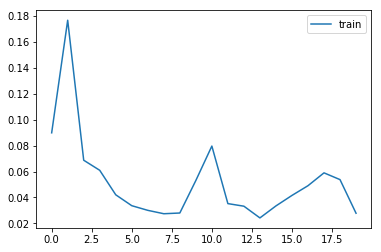

LSTM_nodes:  50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50)                12400     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
 - 1s - loss: 0.0635
Epoch 2/20
 - 0s - loss: 0.1232
Epoch 3/20
 - 0s - loss: 0.0509
Epoch 4/20
 - 0s - loss: 0.0385
Epoch 5/20
 - 0s - loss: 0.0317
Epoch 6/20
 - 0s - loss: 0.0427
Epoch 7/20
 - 0s - loss: 0.0370
Epoch 8/20
 - 0s - loss: 0.0399
Epoch 9/20
 - 0s - loss: 0.0559
Epoch 10/20
 - 0s - loss: 0.0646
Epoch 11/20
 - 0s - loss: 0.0409
Epoch 12/20
 - 0s - loss: 0.0416
Epoch 13/20
 - 0s - loss: 0.0429
Epoch 14/20
 - 0s - loss: 0.0288
Epoch 15/20
 - 0s - loss: 0.0318
Epoch 16/20
 - 0s - loss: 0.0576

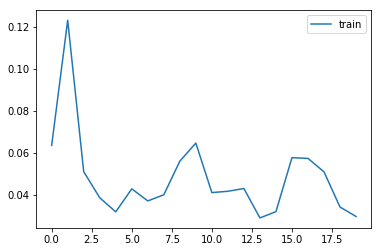

LSTM_nodes:  60
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60)                17280     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 61        
Total params: 17,341
Trainable params: 17,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
 - 2s - loss: 0.1231
Epoch 2/20
 - 0s - loss: 0.0682
Epoch 3/20
 - 0s - loss: 0.0721
Epoch 4/20
 - 0s - loss: 0.1164
Epoch 5/20
 - 0s - loss: 0.1422
Epoch 6/20
 - 0s - loss: 0.0621
Epoch 7/20
 - 0s - loss: 0.0418
Epoch 8/20
 - 0s - loss: 0.0373
Epoch 9/20
 - 0s - loss: 0.0295
Epoch 10/20
 - 0s - loss: 0.0381
Epoch 11/20
 - 0s - loss: 0.0533
Epoch 12/20
 - 0s - loss: 0.0716
Epoch 13/20
 - 0s - loss: 0.0433
Epoch 14/20
 - 0s - loss: 0.0435
Epoch 15/20
 - 0s - loss: 0.0388
Epoch 16/20
 - 0s - loss: 0.0330

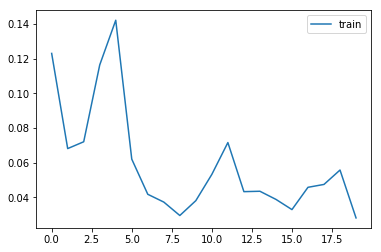

n_days =  20
n_obs:  220
LSTM_nodes:  30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30)                5040      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
Total params: 5,071
Trainable params: 5,071
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
 - 2s - loss: 0.1596
Epoch 2/20
 - 0s - loss: 0.2455
Epoch 3/20
 - 0s - loss: 0.0937
Epoch 4/20
 - 0s - loss: 0.0650
Epoch 5/20
 - 0s - loss: 0.0567
Epoch 6/20
 - 0s - loss: 0.0533
Epoch 7/20
 - 0s - loss: 0.0399
Epoch 8/20
 - 0s - loss: 0.0419
Epoch 9/20
 - 0s - loss: 0.0615
Epoch 10/20
 - 0s - loss: 0.0593
Epoch 11/20
 - 0s - loss: 0.0588
Epoch 12/20
 - 0s - loss: 0.0456
Epoch 13/20
 - 0s - loss: 0.0459
Epoch 14/20
 - 0s - loss: 0.0309
Epoch 15/20
 - 0s - loss: 0.0339
Epoch 16/

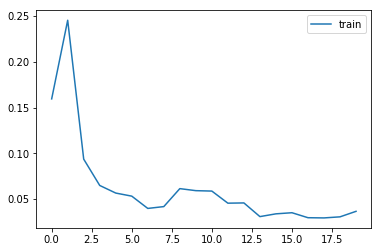

LSTM_nodes:  40
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 40)                8320      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 41        
Total params: 8,361
Trainable params: 8,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
 - 2s - loss: 0.1235
Epoch 2/20
 - 0s - loss: 0.1154
Epoch 3/20
 - 0s - loss: 0.0761
Epoch 4/20
 - 0s - loss: 0.0776
Epoch 5/20
 - 0s - loss: 0.0781
Epoch 6/20
 - 0s - loss: 0.0615
Epoch 7/20
 - 0s - loss: 0.0391
Epoch 8/20
 - 0s - loss: 0.0511
Epoch 9/20
 - 0s - loss: 0.0615
Epoch 10/20
 - 0s - loss: 0.0535
Epoch 11/20
 - 0s - loss: 0.0337
Epoch 12/20
 - 0s - loss: 0.0384
Epoch 13/20
 - 0s - loss: 0.0468
Epoch 14/20
 - 0s - loss: 0.0441
Epoch 15/20
 - 0s - loss: 0.0335
Epoch 16/20
 - 0s - loss: 0.0378
E

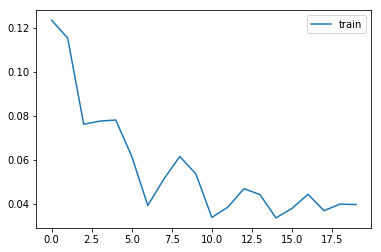

LSTM_nodes:  50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 50)                12400     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
 - 2s - loss: 0.0720
Epoch 2/20
 - 0s - loss: 0.1314
Epoch 3/20
 - 0s - loss: 0.0527
Epoch 4/20
 - 0s - loss: 0.0761
Epoch 5/20
 - 0s - loss: 0.0627
Epoch 6/20
 - 0s - loss: 0.0368
Epoch 7/20
 - 0s - loss: 0.0570
Epoch 8/20
 - 0s - loss: 0.0725
Epoch 9/20
 - 0s - loss: 0.0607
Epoch 10/20
 - 0s - loss: 0.0288
Epoch 11/20
 - 0s - loss: 0.0331
Epoch 12/20
 - 0s - loss: 0.0450
Epoch 13/20
 - 0s - loss: 0.0453
Epoch 14/20
 - 0s - loss: 0.0301
Epoch 15/20
 - 0s - loss: 0.0316
Epoch 16/20
 - 0s - loss: 0.0364

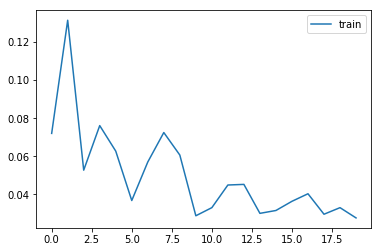

LSTM_nodes:  60
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 60)                17280     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 61        
Total params: 17,341
Trainable params: 17,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
 - 2s - loss: 0.1285
Epoch 2/20
 - 0s - loss: 0.1293
Epoch 3/20
 - 0s - loss: 0.0779
Epoch 4/20
 - 0s - loss: 0.0687
Epoch 5/20
 - 0s - loss: 0.0405
Epoch 6/20
 - 0s - loss: 0.0523
Epoch 7/20
 - 0s - loss: 0.0468
Epoch 8/20
 - 0s - loss: 0.0542
Epoch 9/20
 - 0s - loss: 0.0443
Epoch 10/20
 - 0s - loss: 0.0600
Epoch 11/20
 - 0s - loss: 0.0374
Epoch 12/20
 - 0s - loss: 0.0377
Epoch 13/20
 - 0s - loss: 0.0288
Epoch 14/20
 - 0s - loss: 0.0333
Epoch 15/20
 - 0s - loss: 0.0392
Epoch 16/20
 - 0s - loss: 0.0479

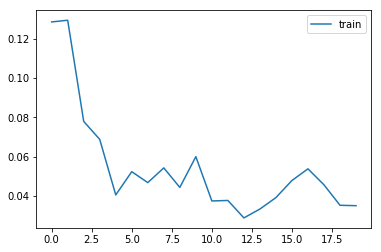

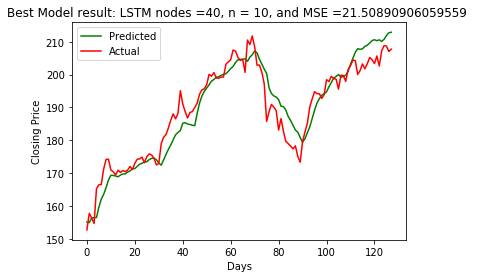

In [19]:
run_model(model1, scaled, LSTM_nodes)

Best model 1 result is with LSTM nodes = 40, number of days = 10 (2weeks), with MSE =21.5

n_days =  5
n_obs:  55
LSTM_nodes:  20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_141 (LSTM)              (None, 20)                2560      
_________________________________________________________________
dropout_135 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_144 (Dense)            (None, 32)                672       
_________________________________________________________________
dropout_136 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 33        
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 83s - loss: 0.2463
Epoch 2/30
 - 0s - loss: 0.2246
Epoch 3/30
 - 0s - loss: 0.1677
Epoc

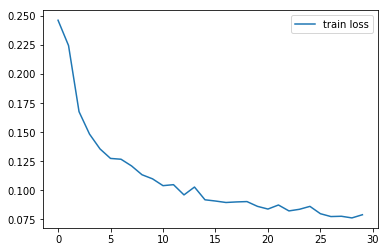

LSTM_nodes:  30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_142 (LSTM)              (None, 30)                5040      
_________________________________________________________________
dropout_137 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_146 (Dense)            (None, 32)                992       
_________________________________________________________________
dropout_138 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_147 (Dense)            (None, 1)                 33        
Total params: 6,065
Trainable params: 6,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 28s - loss: 0.2158
Epoch 2/30
 - 0s - loss: 0.1774
Epoch 3/30
 - 0s - loss: 0.1422
Epoch 4/30
 - 0s - loss: 0.

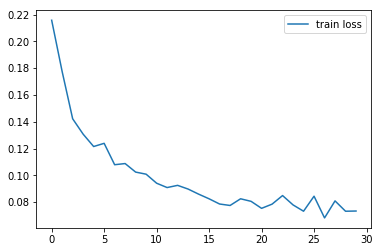

LSTM_nodes:  40
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_143 (LSTM)              (None, 40)                8320      
_________________________________________________________________
dropout_139 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_148 (Dense)            (None, 32)                1312      
_________________________________________________________________
dropout_140 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_149 (Dense)            (None, 1)                 33        
Total params: 9,665
Trainable params: 9,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 26s - loss: 0.2368
Epoch 2/30
 - 0s - loss: 0.2297
Epoch 3/30
 - 0s - loss: 0.1548
Epoch 4/30
 - 0s - loss: 0.

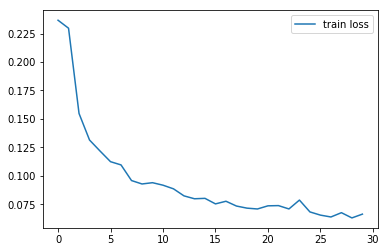

LSTM_nodes:  50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_144 (LSTM)              (None, 50)                12400     
_________________________________________________________________
dropout_141 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_150 (Dense)            (None, 32)                1632      
_________________________________________________________________
dropout_142 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 33        
Total params: 14,065
Trainable params: 14,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 47s - loss: 0.2150
Epoch 2/30
 - 0s - loss: 0.1889
Epoch 3/30
 - 0s - loss: 0.1442
Epoch 4/30
 - 0s - loss: 

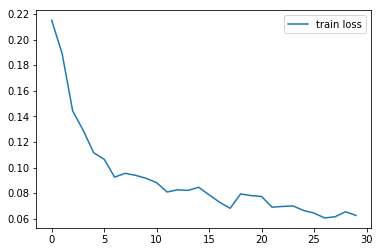

n_days =  10
n_obs:  110
LSTM_nodes:  20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_145 (LSTM)              (None, 20)                2560      
_________________________________________________________________
dropout_143 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_152 (Dense)            (None, 32)                672       
_________________________________________________________________
dropout_144 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 33        
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 33s - loss: 0.3346
Epoch 2/30
 - 0s - loss: 0.2780
Epoch 3/30
 - 0s - loss: 0.2055
Ep

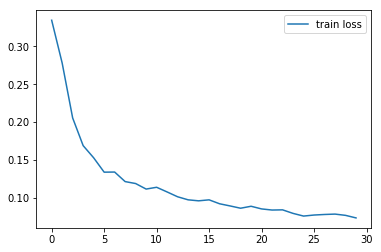

LSTM_nodes:  30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_146 (LSTM)              (None, 30)                5040      
_________________________________________________________________
dropout_145 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_154 (Dense)            (None, 32)                992       
_________________________________________________________________
dropout_146 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_155 (Dense)            (None, 1)                 33        
Total params: 6,065
Trainable params: 6,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 65s - loss: 0.2204
Epoch 2/30
 - 0s - loss: 0.2066
Epoch 3/30
 - 0s - loss: 0.1496
Epoch 4/30
 - 0s - loss: 0.

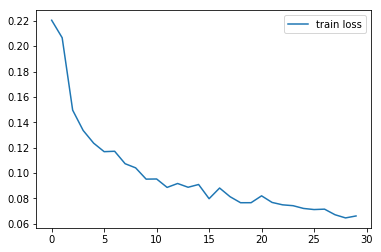

LSTM_nodes:  40
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_147 (LSTM)              (None, 40)                8320      
_________________________________________________________________
dropout_147 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_156 (Dense)            (None, 32)                1312      
_________________________________________________________________
dropout_148 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_157 (Dense)            (None, 1)                 33        
Total params: 9,665
Trainable params: 9,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 46s - loss: 0.2623
Epoch 2/30
 - 0s - loss: 0.2085
Epoch 3/30
 - 0s - loss: 0.1540
Epoch 4/30
 - 0s - loss: 0.

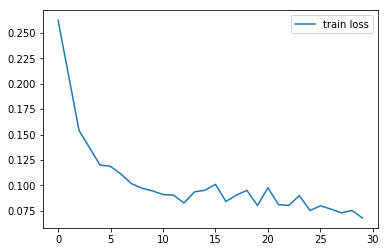

LSTM_nodes:  50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_148 (LSTM)              (None, 50)                12400     
_________________________________________________________________
dropout_149 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_158 (Dense)            (None, 32)                1632      
_________________________________________________________________
dropout_150 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_159 (Dense)            (None, 1)                 33        
Total params: 14,065
Trainable params: 14,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 56s - loss: 0.2011
Epoch 2/30
 - 1s - loss: 0.1701
Epoch 3/30
 - 1s - loss: 0.1428
Epoch 4/30
 - 0s - loss: 

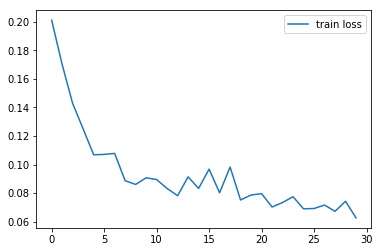

n_days =  20
n_obs:  220
LSTM_nodes:  20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_149 (LSTM)              (None, 20)                2560      
_________________________________________________________________
dropout_151 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_160 (Dense)            (None, 32)                672       
_________________________________________________________________
dropout_152 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_161 (Dense)            (None, 1)                 33        
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 47s - loss: 0.3043
Epoch 2/30
 - 2s - loss: 0.2453
Epoch 3/30
 - 1s - loss: 0.1805
Ep

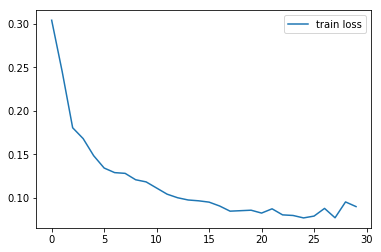

LSTM_nodes:  30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_150 (LSTM)              (None, 30)                5040      
_________________________________________________________________
dropout_153 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_162 (Dense)            (None, 32)                992       
_________________________________________________________________
dropout_154 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_163 (Dense)            (None, 1)                 33        
Total params: 6,065
Trainable params: 6,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 46s - loss: 0.2391
Epoch 2/30
 - 0s - loss: 0.2443
Epoch 3/30
 - 1s - loss: 0.1532
Epoch 4/30
 - 0s - loss: 0.

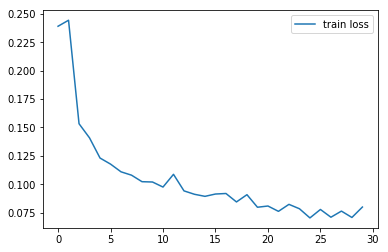

LSTM_nodes:  40
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_151 (LSTM)              (None, 40)                8320      
_________________________________________________________________
dropout_155 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_164 (Dense)            (None, 32)                1312      
_________________________________________________________________
dropout_156 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 33        
Total params: 9,665
Trainable params: 9,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 113s - loss: 0.2376
Epoch 2/30
 - 0s - loss: 0.2291
Epoch 3/30
 - 0s - loss: 0.1514
Epoch 4/30
 - 0s - loss: 0

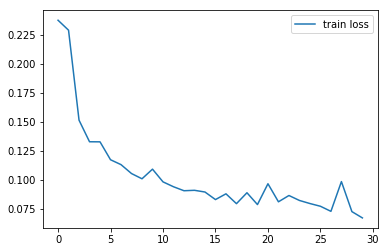

LSTM_nodes:  50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_152 (LSTM)              (None, 50)                12400     
_________________________________________________________________
dropout_157 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_166 (Dense)            (None, 32)                1632      
_________________________________________________________________
dropout_158 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_167 (Dense)            (None, 1)                 33        
Total params: 14,065
Trainable params: 14,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 25s - loss: 0.2045
Epoch 2/30
 - 0s - loss: 0.2163
Epoch 3/30
 - 0s - loss: 0.1408
Epoch 4/30
 - 0s - loss: 

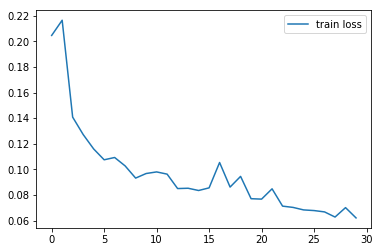

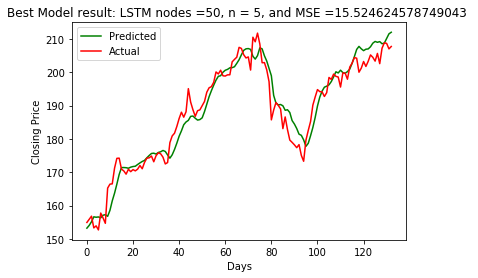

In [120]:
run_model(model2,scaled, LSTM_nodes)


Best model 2 result is with LSTM nodes = 50, number of days = 5 (1week), with MSE =15.5

In conclusion, Model 2 with 50 nodes, 5 days data produces the best MSE result of 15.5.

In [19]:
#Model 3: due to limitation of my laptop computing power, this was not run for the purpose of this project. 
#But it would be interesting to see if complexity improves MSE
#run_model(model3, scaled, LSTM_nodes)
    